In [115]:
import numpy as np
# import pandas as pd
from pathlib import Path
from astropy.stats import sigma_clip
from sunbird.emulators import FCN, train
from sunbird.data import ArrayDataModule
import matplotlib.pyplot as plt
import matplotlib as mpl
# from pycorr import TwoPointCorrelationFunction
import torch
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


def read_lhc(statistic='quantile_data_correlation', n_hod=50_000, return_sep=False):
    if statistic == 'density_split':
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/number_density/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'number_density_lhc.npy'
    else:
        data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/z0.5/yuan23_prior/c000_ph000/seed0/'
        data_fn = Path(data_dir) / f'{statistic}_lhc.npy'
    data = np.load(data_fn, allow_pickle=True).item()
    lhc_x = data['lhc_x'][:n_hod]
    lhc_y = data['lhc_y'][:n_hod]
    lhc_x_names = data['lhc_x_names']
    return lhc_x, lhc_y, lhc_x_names


statistic = 'number_density_downsampled'


lhc_x, lhc_y, lhc_x_names = read_lhc(statistic=statistic, n_hod=50_000)
lhc_y = lhc_y.reshape(len(lhc_y), 1)
print(f'Loaded LHC with shape: {lhc_x.shape}, {lhc_y.shape}')

Loaded LHC with shape: (50000, 12), (50000, 1)


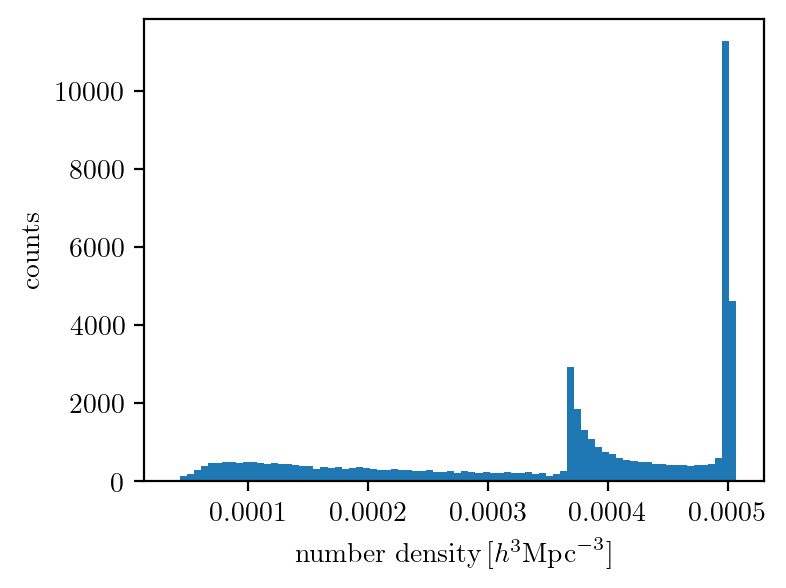

3.6592e-05 0.000507144


In [116]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.hist(lhc_y, bins=80)

ax.set_xlabel(r'$\textrm{number density}\,[h^3{\rm Mpc}^{-3}]$')
ax.set_ylabel(r'$\textrm{counts}$')
plt.show()

print(lhc_y.min(), lhc_y.max())

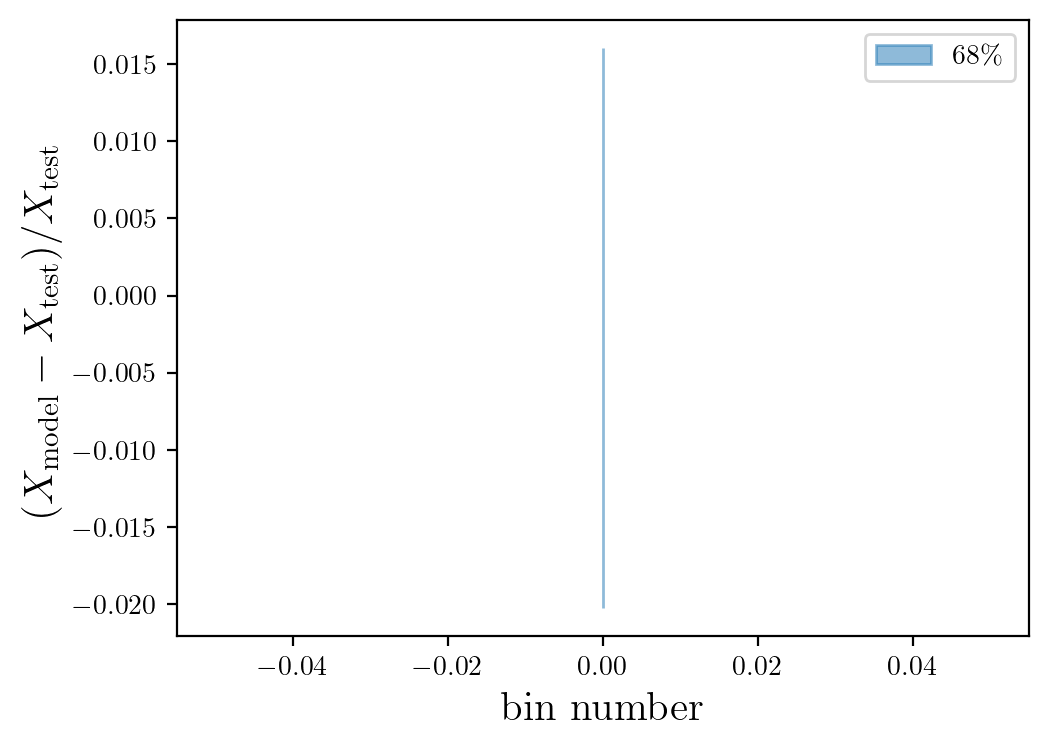

In [117]:
ntot = len(lhc_y)
nstep = int(ntot / 5)
q68_all = []
q95_all = []
emuerr_all = []
emulator_error_all = []
for i in range(5):
    start_idx = i * nstep
    end_idx = (i + 1) * nstep
    idx_train = list(range(0, start_idx)) + list(range(end_idx, ntot))
    idx_test = list(range(start_idx, end_idx))

    lhc_train_x = lhc_x[idx_train]
    lhc_train_y = lhc_y[idx_train]
    lhc_test_x = lhc_x[idx_test]
    lhc_test_y = lhc_y[idx_test]
    
    # checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/number_density_raw/jun19_leaveout_{i}/last-v1.ckpt'
    checkpoint_fn = f'/pscratch/sd/e/epaillas/emc/trained_models/number_density_downsampled/jun19_leaveout_{i}/last.ckpt'
    model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
    model.eval()
    
    with torch.no_grad():
        pred_test_y = model.get_prediction(torch.Tensor(lhc_test_x))
        pred_test_y = pred_test_y.numpy()
        
    emulator_error = (pred_test_y - lhc_test_y)/lhc_test_y
    # emulator_error = (pred_test_y - lhc_test_y)/lhc_test_y
    q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
    q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
    q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)
    
    q68_all.append(q68)
    q95_all.append(q95)
    emulator_error_all.append((pred_test_y - lhc_test_y)/lhc_test_y)
    # emulator_error_all.append((pred_test_y - lhc_test_y)/lhc_test_y)
    # emuerr_all.append(pred_test_y - lhc_test_y)
    
    # fig, ax = plt.subplots(figsize=(4, 3))
    # ax.plot(lhc_test_y[0], marker='o', ls='')
    # ax.plot(pred_test_y[0])
    # plt.show()
    
# # plt.show()
    
# # q68_all = np.array(q68_all).mean(axis=0)
# # q95_all = np.array(q95_all).mean(axis=0)
emulator_error_all = np.concatenate(emulator_error_all)
q68_all = np.quantile(emulator_error_all, [0.16, 0.84], axis=0)
q95_all = np.quantile(emulator_error_all, [0.025, 0.975], axis=0)
emu_cov = np.cov(emulator_error_all, rowvar=False)
                      
fig, ax = plt.subplots(figsize=(5.5, 4))
ax.fill_between(list(range(emulator_error.shape[1])), q68_all[0], q68_all[1], alpha=0.5, label='68\%', color='C0')
# ax.fill_between(list(range(emulator_error.shape[1])), q95_all[0], q95_all[1], alpha=0.5, label='95\%', color='C1')
ax.legend()
ax.set_xlabel('bin number', fontsize=15)
ax.set_ylabel('(model - test)/test', fontsize=15)
ax.set_ylabel(r'$(X_{\rm model} - X_{\rm test})/X_{\rm test}$', fontsize=15)
# plt.ylim(-0.1,0.1)
# ax.fill_between(list(range(len(s)), q68_all[0], q68_all[1], alpha=0.5, color='crimson'))
plt.show()

(0.964894, 0.902323, 0.123941, 1.0)


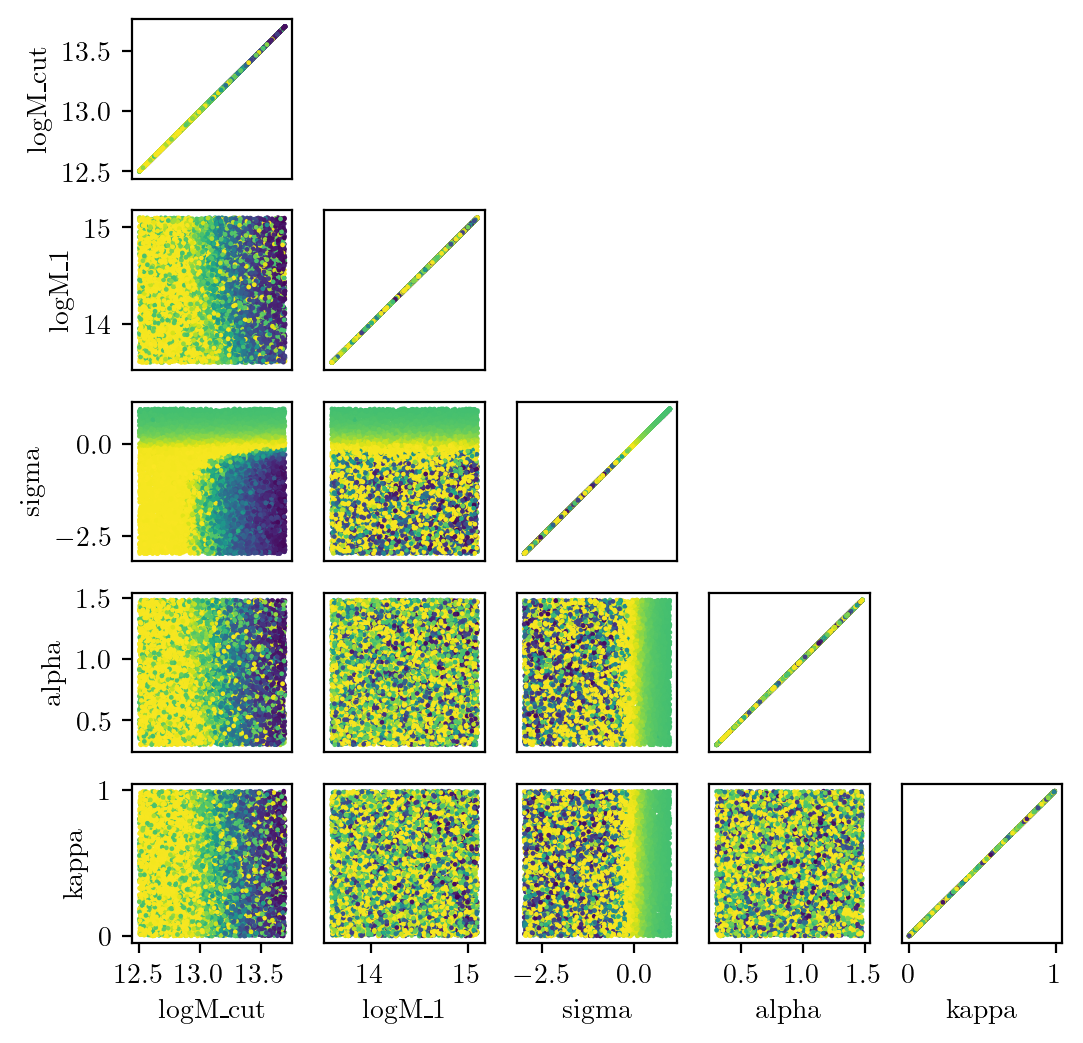

In [118]:
nsamples = 10_000
hods = lhc_x[:nsamples]

with torch.no_grad():
    pred_y = model.get_prediction(torch.Tensor(hods))
    pred_y = pred_y.numpy()
    
ndim = 5
fig, ax = plt.subplots(ndim, ndim, figsize=(6, 6))
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=lhc_y.min(), vmax=lhc_y.max())
print(cmap(norm(5e-4)))

for i in range(ndim):
    for j in range(ndim):
        # ax[i][j].scatter(hods[:, j], hods[:, i], c=pred_y[:nsamples], s=1.0)
        sc = ax[i][j].scatter(hods[:, j], hods[:, i], c=cmap(norm(lhc_y[:nsamples])), s=0.5)

        ax[i][j].set_xlabel(lhc_x_names[j])
        ax[i][j].set_ylabel(lhc_x_names[i])
        
        if i < j: fig.delaxes(ax[i, j])
        if i < ndim - 1: ax[i, j].axes.get_xaxis().set_visible(False)
        if j > 0: ax[i, j].axes.get_yaxis().set_visible(False)
        

# plt.tight_layout()
plt.show()